In [2]:
from google.colab import drive
drive.mount('/content/drive')
TILES_DIR = "/content/drive/MyDrive/Trees_Data/_tiles/train_val_PNG"  # .png + .json
# OUTPUT: a COCO dataset (images + annotations)
OUT_ROOT = "/content/drive/MyDrive/fallen_trees_coco_tiles"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json, random, os, shutil
from pathlib import Path
from PIL import Image

# ---- config ----
CATEGORY_NAME = "fallen_tree"
CATEGORY_ID   = 1
VAL_FRACTION  = 0.1              # ~10% val;
SPLIT_SEED    = 123              # deterministic split

TILES_DIR = Path(TILES_DIR)
OUT_ROOT  = Path(OUT_ROOT)

IMG_TRAIN  = OUT_ROOT/"images"/"train"
IMG_VAL    = OUT_ROOT/"images"/"val"
ANN_DIR    = OUT_ROOT/"annotations"
for p in [IMG_TRAIN, IMG_VAL, ANN_DIR]:
    p.mkdir(parents=True, exist_ok=True)

def label_ok(s: str) -> bool:
    s = (s or "").strip().lower().replace("-","_").replace(" ","_")
    return s == "fallen_tree"

def polygon_area(flat):
    import numpy as np
    pts = np.asarray(flat, dtype=np.float32).reshape(-1,2)
    x,y = pts[:,0], pts[:,1]
    return float(0.5*abs((x*np.roll(y,-1)).sum() - (y*np.roll(x,-1)).sum()))

def to_coco_ann(polys_flat, W, H, image_id, next_ann_id):
    anns=[]
    ann_id = next_ann_id
    for flat in polys_flat:
        if len(flat) < 6:
            continue
        xs = flat[0::2]; ys = flat[1::2]
        x1,y1 = max(0,min(xs)), max(0,min(ys))
        x2,y2 = min(W-1,max(xs)), min(H-1,max(ys))
        w,h = max(0.0,x2-x1), max(0.0,y2-y1)
        if w<=0 or h<=0:
            continue
        area = polygon_area(flat)
        anns.append({
            "id": ann_id,
            "image_id": image_id,
            "category_id": CATEGORY_ID,
            "segmentation": [ [float(v) for v in flat] ],
            "area": float(area),
            "bbox": [float(x1), float(y1), float(w), float(h)],
            "iscrowd": 0
        })
        ann_id += 1
    return anns, ann_id

def load_labelme(jp: Path):
    j = json.loads(jp.read_text())
    polys=[]
    w = j.get("imageWidth"); h = j.get("imageHeight")
    for s in j.get("shapes", []):
        if not label_ok(s.get("label")):
            continue
        pts = s.get("points", [])
        if len(pts) < 3: continue
        flat=[]
        for (x,y) in pts:
            flat += [float(x), float(y)]
        polys.append(flat)
    return w, h, polys

def convert(pairs, split_name, out_img_dir):
    images, annotations = [], []
    img_id, ann_id = 1, 1
    for png, jp in sorted(pairs):
        w, h, polys = load_labelme(jp)
        if w is None or h is None:
            with Image.open(png) as im:
                w, h = im.size

        dst = out_img_dir / png.name
        if not dst.exists():
            shutil.copy2(png, dst)

        images.append({
            "id": img_id,
            "file_name": png.name,
            "width": int(w),
            "height": int(h)
        })
        anns, ann_id = to_coco_ann(polys, w, h, img_id, ann_id)
        annotations.extend(anns)
        img_id += 1

    coco = {
        "images": images,
            "annotations": annotations,
            "categories": [{"id": CATEGORY_ID, "name": CATEGORY_NAME}]
    }
    out_json = ANN_DIR/f"{split_name}.json"
    out_json.write_text(json.dumps(coco))
    print(f"{split_name}: images={len(images)} anns={len(annotations)} -> {out_json}")
    return out_json

pairs=[]
for png in sorted(TILES_DIR.glob("*.png")):
    jp = TILES_DIR / (png.stem + ".json")
    if jp.exists():
        pairs.append((png, jp))

if not pairs:
    raise RuntimeError("No (png,json) pairs found under TILES_DIR.")


random.Random(SPLIT_SEED).shuffle(pairs)
n_val = max(1, int(len(pairs)*VAL_FRACTION))
val_pairs   = pairs[:n_val]
train_pairs = pairs[n_val:]

train_json = convert(train_pairs, "train", IMG_TRAIN)
val_json   = convert(val_pairs,   "val",   IMG_VAL)
print("DONE.")


train: images=66 anns=447 -> /content/drive/MyDrive/fallen_trees_coco_tiles/annotations/train.json
val: images=7 anns=65 -> /content/drive/MyDrive/fallen_trees_coco_tiles/annotations/val.json
DONE.


In [ ]:
!pip -q install pycocotools
from pycocotools.coco import COCO
from pathlib import Path

root = Path(OUT_ROOT)
for split in ["train","val"]:
    js = root/"annotations"/f"{split}.json"
    img_dir = root/"images"/split
    coco = COCO(str(js))
    assert len(coco.imgs)>0, f"{split}: no images in JSON"
    ann_ids = coco.getAnnIds()
    assert len(ann_ids)>0, f"{split}: no annotations in JSON"
    # file existence
    for img_id, img in coco.imgs.items():
        f = img_dir/img["file_name"]
        if not f.exists():
            raise FileNotFoundError(f"{split}: missing file {f}")
print("COCO structure looks good")


In [ ]:
import random, numpy as np, cv2
from pycocotools.coco import COCO
from pathlib import Path

def show_random_samples(split="val", k=3):
    js = Path(OUT_ROOT)/"annotations"/f"{split}.json"
    img_dir = Path(OUT_ROOT)/"images"/split
    coco = COCO(str(js))
    ids = list(coco.imgs.keys())
    random.shuffle(ids)
    ids = ids[:min(k, len(ids))]

    for img_id in ids:
        info = coco.imgs[img_id]
        img = cv2.cvtColor(cv2.imread(str(img_dir/info['file_name'])), cv2.COLOR_BGR2RGB)
        ann_ids = coco.getAnnIds(imgIds=[img_id], iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        canvas = img.copy()
        for a in anns:
            for seg in a.get("segmentation", []):
                pts = np.asarray(seg, np.float32).reshape(-1,2).astype(np.int32)
                cv2.polylines(canvas, [pts], True, (255,0,0), 2)
        display(Image.fromarray(canvas))

show_random_samples("val", k=3)


##Finished preprocessing to COCO Format Now start fine-tuning

In [ ]:
!pip -q install timm==0.9.16 pycocotools==2.0.7

import os, json, math, random, time
from pathlib import Path

import numpy as np
import torch, torch.nn as nn
import torch.utils.data as data
import torchvision
from torchvision.ops import FeaturePyramidNetwork, MultiScaleRoIAlign
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

from PIL import Image, ImageOps
import cv2
import timm

torch.__version__, torchvision.__version__, timm.__version__


In [13]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_ROOT = Path("/content/drive/MyDrive/fallen_trees_coco_tiles")
TRAIN_JSON   = DATASET_ROOT/"annotations"/"train.json"
VAL_JSON     = DATASET_ROOT/"annotations"/"val.json"
TRAIN_DIR    = DATASET_ROOT/"images"/"train"
VAL_DIR      = DATASET_ROOT/"images"/"val"

assert TRAIN_JSON.exists() and VAL_JSON.exists(), "COCO JSONs not found. Run the converter first."
assert TRAIN_DIR.exists() and VAL_DIR.exists(),   "Image folders not found. Run the converter first."


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class COCOPolygonDataset(data.Dataset):
    def __init__(self, img_dir: Path, ann_json: Path, out_size=256, augment=False):
        self.img_dir = Path(img_dir)
        self.coco = json.loads(Path(ann_json).read_text())
        self.id_to_img = {im["id"]: im for im in self.coco["images"]}

        self.img_to_anns = {im["id"]: [] for im in self.coco["images"]}
        for a in self.coco["annotations"]:
            self.img_to_anns[a["image_id"]].append(a)

        self.img_ids = []
        for im in self.coco["images"]:
            if (self.img_dir / im["file_name"]).exists():
                self.img_ids.append(im["id"])

        self.out_size = int(out_size)
        self.augment = augment

    def __len__(self):
        return len(self.img_ids)

    @staticmethod
    def _poly_to_mask(polys, H, W):

        masks = []
        for flat in polys:
            if len(flat) < 6:
                continue
            pts = np.asarray(flat, np.float32).reshape(-1,2)
            canvas = np.zeros((H, W), dtype=np.uint8)
            cv2.fillPoly(canvas, [pts.astype(np.int32)], 1)
            masks.append(canvas)
        if len(masks)==0:
            return np.zeros((0, H, W), dtype=np.uint8)
        return np.stack(masks, axis=0)

    def __getitem__(self, idx):
        img_id  = self.img_ids[idx]
        im_info = self.id_to_img[img_id]
        fpath   = self.img_dir / im_info["file_name"]

        img = Image.open(fpath).convert("RGB")
        W0, H0 = img.size

        anns = self.img_to_anns.get(img_id, [])

        flip = self.augment and (random.random() < 0.5)
        if flip:
            img = ImageOps.mirror(img)

        # Scale factors to out_size
        outH = outW = self.out_size
        sx = outW / float(W0)
        sy = outH / float(H0)

        # Scale polygons, apply optional, then rasterize at target size
        polys_scaled = []
        boxes_scaled = []
        labels = []

        for a in anns:
            segs = a.get("segmentation", [])
            for seg in segs:
                # seg is a flat list: [x1,y1,x2,y2,...]
                pts = np.asarray(seg, np.float32).reshape(-1,2)
                if flip:
                    pts[:,0] = (W0 - 1) - pts[:,0]  # horizontal flip
                pts[:,0] *= sx
                pts[:,1] *= sy
                flat = pts.reshape(-1).tolist()
                polys_scaled.append(flat)

            # use bbox if present (scale + optional flip); otherwise compute from seg
            if "bbox" in a and len(a["bbox"])==4:
                x,y,w,h = a["bbox"]
                if flip:
                    x = (W0 - (x + w))  # flip bbox x
                x *= sx; y *= sy; w *= sx; h *= sy
                boxes_scaled.append([x, y, max(1.0, w), max(1.0, h)])
            labels.append(int(a.get("category_id", 1)))

        # If bbox list and polygon list count don't match, recompute boxes from polygons
        if len(boxes_scaled) != len(polys_scaled):
            boxes_scaled = []

            for flat in polys_scaled:
                xs = flat[0::2]; ys = flat[1::2]
                x1,y1 = max(0.0, min(xs)), max(0.0, min(ys))
                x2,y2 = min(outW-1.0, max(xs)), min(outH-1.0, max(ys))
                boxes_scaled.append([x1, y1, max(1.0, x2-x1), max(1.0, y2-y1)])

        # rasterize polygons at target size
        masks = self._poly_to_mask(polys_scaled, outH, outW)  # (N,H,W)

        # convert everything to tensors for Mask R-CNN
        img_t = F.to_tensor(img.resize((outW, outH), Image.BILINEAR))  # [C,H,W], float in [0,1]

        if masks.shape[0] == 0:
            # Make a dummy background sample (no instances)
            target = {
                "boxes": torch.zeros((0,4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64),
                "masks": torch.zeros((0, outH, outW), dtype=torch.uint8),
                "image_id": torch.tensor([img_id]),
                "area": torch.zeros((0,), dtype=torch.float32),
                "iscrowd": torch.zeros((0,), dtype=torch.int64),
            }
            return img_t, target

        boxes_xyxy = []
        areas = []
        for (x,y,w,h) in boxes_scaled:
            x2 = x + w
            y2 = y + h
            boxes_xyxy.append([x, y, x2, y2])
            areas.append(w*h)

        target = {
            "boxes": torch.tensor(boxes_xyxy, dtype=torch.float32),
            "labels": torch.tensor(labels[:len(boxes_xyxy)], dtype=torch.int64),
            "masks": torch.from_numpy(masks),                           # uint8 [N,H,W]
            "image_id": torch.tensor([img_id]),
            "area": torch.tensor(areas[:len(boxes_xyxy)], dtype=torch.float32),
            "iscrowd": torch.zeros((len(boxes_xyxy),), dtype=torch.int64),
        }
        return img_t, target

def collate_fn(batch):
    return tuple(zip(*batch))


In [3]:
import torch, torch.nn as nn
from torchvision.models.detection import MaskRCNN
from torchvision.ops import FeaturePyramidNetwork, MultiScaleRoIAlign
from torchvision.models.detection.rpn import AnchorGenerator
import timm

# -----------------------------
# 1) SwinV2 backbone (timm)
# -----------------------------
SWINV2_NAME = 'swinv2_tiny_window16_256'  # For better mAP I need to make this more than 256
swin = timm.create_model(
    SWINV2_NAME,
    pretrained=True,
    features_only=True,
    out_indices=(0, 1, 2, 3)
)
feat_channels = swin.feature_info.channels()  # e.g. [96, 192, 384, 768]

# -----------------------------
# 2) FPN on top of SwinV2
# -----------------------------
fpn = FeaturePyramidNetwork(in_channels_list=feat_channels, out_channels=256)

class SwinV2FPN(nn.Module):
    def __init__(self, body, fpn):
        super().__init__()
        self.body = body
        self.fpn = fpn
        self.out_channels = 256

    def _to_nchw(self, t):
        # Ensure NCHW before FPN
        if t.ndim == 4 and t.shape[1] < t.shape[-1]:  # likely NHWC
            t = t.permute(0, 3, 1, 2).contiguous()
        return t

    def forward(self, x):
        feats = self.body(x)                   # list of 4 tensors
        feats = [self._to_nchw(f) for f in feats]
        feats = {str(i): f for i, f in enumerate(feats)}  # keys: '0','1','2','3'
        outs = self.fpn(feats)                 # torchvision FPN (4 maps by default)
        return outs

backbone = SwinV2FPN(swin, fpn)

# -----------------------------
# 3) Build temporary model
#    (we'll rebind anchors/ROI after probing FPN)
# -----------------------------
num_classes = 2  # background + Fallen_tree
tmp_anchor = AnchorGenerator(sizes=((32,),), aspect_ratios=((0.5, 1.0, 2.0),))
tmp_roi    = MultiScaleRoIAlign(featmap_names=['0'], output_size=7,  sampling_ratio=2)
tmp_mroi   = MultiScaleRoIAlign(featmap_names=['0'], output_size=14, sampling_ratio=2)

model = MaskRCNN(
    backbone,
    num_classes=num_classes,
    rpn_anchor_generator=tmp_anchor,
    box_roi_pool=tmp_roi,
    mask_roi_pool=tmp_mroi
)

# Keep transforms at 256x256 to match swinv2_tiny_window16_256
model.transform.min_size = (256,)
model.transform.max_size = 256

# Filter weak detections at test-time
model.roi_heads.score_thresh = 0.6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# -----------------------------
# 4) Probe FPN → rebuild anchors & ROI poolers to match
# -----------------------------
model.eval()
with torch.no_grad():
    dummy = torch.zeros(1, 3, 256, 256, device=device)
    feats = model.backbone(dummy)  # OrderedDict of feature maps
    fmap_names = list(feats.keys())              # e.g. ['0','1','2','3']
    fmap_shapes = [tuple(t.shape) for t in feats.values()]
print("FPN maps:", fmap_names)
print("FPN shapes:", fmap_shapes)
n_levels = len(fmap_names)

base = [32, 64, 128, 256, 512, 1024]  # slice to n_levels
sizes  = tuple((base[i],) for i in range(n_levels))
ratios = ((0.5, 1.0, 2.0),) * n_levels

model.rpn.anchor_generator = AnchorGenerator(sizes=sizes, aspect_ratios=ratios)
model.roi_heads.box_roi_pool  = MultiScaleRoIAlign(featmap_names=fmap_names, output_size=7,  sampling_ratio=2)
model.roi_heads.mask_roi_pool = MultiScaleRoIAlign(featmap_names=fmap_names, output_size=14, sampling_ratio=2)

print("Anchor sizes per level:", sizes)
print("Aspect ratios per level:", ratios)

# -----------------------------
# 5) One synthetic training step
# -----------------------------
H, W = 256, 256
img  = torch.rand(3, H, W)                          # [C,H,W] in [0,1]
box  = torch.tensor([[40., 50., 180., 200.]], dtype=torch.float32)  # [x1,y1,x2,y2]
label= torch.tensor([1], dtype=torch.int64)         # 1 = Fallen_tree
mask = torch.zeros((1, H, W), dtype=torch.uint8)
mask[0, 60:190, 60:190] = 1

target = {
    "boxes": box,
    "labels": label,
    "masks": mask,
    "image_id": torch.tensor([1]),
    "area": torch.tensor([float((180-40)*(200-50))]),
    "iscrowd": torch.tensor([0]),
}

model.train()
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4, weight_decay=5e-2)

imgs = [img.to(device)]
tgts = [{k: v.to(device) for k, v in target.items()}]

losses = model(imgs, tgts)  # dict
loss = sum(losses.values())
optimizer.zero_grad()
loss.backward()
optimizer.step()

print("Train step OK. Loss:", {k: float(v.detach().cpu()) for k, v in losses.items()})

# -----------------------------
# 6) Quick inference on same image
# -----------------------------
model.eval()
with torch.no_grad():
    out = model([img.to(device)])[0]
    print("Pred boxes:", out["boxes"][:3].detach().cpu())
    print("Pred scores:", out["scores"][:3].detach().cpu())
    print("Pred masks shape:", out["masks"].shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/119M [00:00<?, ?B/s]

FPN maps: ['0', '1', '2', '3']
FPN shapes: [(1, 256, 64, 64), (1, 256, 32, 32), (1, 256, 16, 16), (1, 256, 8, 8)]
Anchor sizes per level: ((32,), (64,), (128,), (256,))
Aspect ratios per level: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
Train step OK. Loss: {'loss_classifier': 0.5857386589050293, 'loss_box_reg': 0.03156507760286331, 'loss_mask': 41.62716293334961, 'loss_objectness': 0.5143190622329712, 'loss_rpn_box_reg': 0.01472906582057476}
Pred boxes: tensor([], size=(0, 4))
Pred scores: tensor([])
Pred masks shape: torch.Size([0, 1, 256, 256])


In [ ]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

DATASET_ROOT = Path("/content/drive/MyDrive/fallen_trees_coco_tiles")
TRAIN_JSON   = DATASET_ROOT/"annotations"/"train.json"
VAL_JSON     = DATASET_ROOT/"annotations"/"val.json"
TRAIN_DIR    = DATASET_ROOT/"images"/"train"
VAL_DIR      = DATASET_ROOT/"images"/"val"

assert TRAIN_JSON.exists() and VAL_JSON.exists(), "COCO JSONs not found."
assert TRAIN_DIR.exists() and VAL_DIR.exists(),   "Image folders not found."
print("Dataset looks good.")


In [10]:
import json, random, numpy as np, cv2
from PIL import Image, ImageOps
from torchvision.transforms import functional as TF
import torch.utils.data as data

class COCOTilesDataset(data.Dataset):
    def __init__(self, img_dir, ann_json, out_size=256, augment=False):
        self.img_dir = Path(img_dir)
        self.coco = json.loads(Path(ann_json).read_text())
        self.id2img = {im["id"]: im for im in self.coco["images"]}
        self.img_to_anns = {im["id"]: [] for im in self.coco["images"]}
        for a in self.coco["annotations"]:
            self.img_to_anns[a["image_id"]].append(a)
        self.img_ids = [im["id"] for im in self.coco["images"]
                        if (self.img_dir / im["file_name"]).exists()]
        self.out_size = int(out_size)
        self.augment = augment

    def __len__(self): return len(self.img_ids)

    @staticmethod
    def _poly_to_mask(polys, H, W):
        ms = []
        for flat in polys:
            if len(flat) < 6: continue
            pts = np.asarray(flat, np.float32).reshape(-1,2)
            canvas = np.zeros((H,W), np.uint8)
            cv2.fillPoly(canvas, [pts.astype(np.int32)], 1)
            ms.append(canvas)
        if not ms: return np.zeros((0,H,W), np.uint8)
        return np.stack(ms,0)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        im = self.id2img[img_id]
        path = self.img_dir / im["file_name"]
        img = Image.open(path).convert("RGB")
        W0, H0 = img.size

        anns = self.img_to_anns.get(img_id, [])

        # simple hflip augment before resizing
        do_flip = self.augment and (random.random() < 0.5)
        if do_flip: img = ImageOps.mirror(img)

        outH=outW=self.out_size
        sx, sy = outW/float(W0), outH/float(H0)

        polys_scaled, boxes_scaled, labels = [], [], []
        for a in anns:
            for seg in a.get("segmentation", []):
                pts = np.asarray(seg, np.float32).reshape(-1,2)
                if do_flip: pts[:,0] = (W0 - 1) - pts[:,0]
                pts[:,0] *= sx; pts[:,1] *= sy
                polys_scaled.append(pts.reshape(-1).tolist())
            labels.append(int(a.get("category_id", 1)))

        if len(polys_scaled):
            # derive boxes from polygons (avoids mismatches)
            for flat in polys_scaled:
                xs = flat[0::2]; ys = flat[1::2]
                x1,y1 = max(0.0, min(xs)), max(0.0, min(ys))
                x2,y2 = min(outW-1.0, max(xs)), min(outH-1.0, max(ys))
                boxes_scaled.append([x1,y1,x2,y2])

        img_r = img.resize((outW,outH), Image.BILINEAR)
        img_t = TF.to_tensor(img_r)

        if len(polys_scaled)==0:
            target = {
                "boxes": torch.zeros((0,4), torch.float32),
                "labels": torch.zeros((0,), torch.int64),
                "masks": torch.zeros((0,outH,outW), torch.uint8),
                "image_id": torch.tensor([img_id]),
                "area": torch.zeros((0,), torch.float32),
                "iscrowd": torch.zeros((0,), torch.int64),
            }
            return img_t, target

        masks = self._poly_to_mask(polys_scaled, outH, outW)
        areas = [(x2-x1)*(y2-y1) for x1,y1,x2,y2 in boxes_scaled]

        target = {
            "boxes": torch.tensor(boxes_scaled, dtype=torch.float32),
            "labels": torch.tensor([1]*len(boxes_scaled), dtype=torch.int64),
            "masks": torch.from_numpy(masks),
            "image_id": torch.tensor([img_id]),
            "area": torch.tensor(areas, dtype=torch.float32),
            "iscrowd": torch.zeros((len(boxes_scaled),), dtype=torch.int64),
        }
        return img_t, target

def collate_fn(batch): return tuple(zip(*batch))


In [14]:
BATCH_SIZE = 4 if torch.cuda.is_available() else 1
NUM_WORKERS = 2
SIZE = 256

train_ds = COCOTilesDataset(TRAIN_DIR, TRAIN_JSON, out_size=SIZE, augment=True)
val_ds   = COCOTilesDataset(VAL_DIR,   VAL_JSON,   out_size=SIZE, augment=False)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True,
                                           collate_fn=collate_fn)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                                           num_workers=NUM_WORKERS, pin_memory=True,
                                           collate_fn=collate_fn)

print("Train/Val counts:", len(train_ds), len(val_ds))


Train/Val counts: 52 21


In [ ]:
import time

def train_one_epoch(model, loader, optimizer, device, epoch, log_every=25):
    model.train()
    running = {}
    t0=time.time()
    for it,(imgs, tgts) in enumerate(loader):
        imgs = [im.to(device) for im in imgs]
        tgts = [{k:v.to(device) for k,v in t.items()} for t in tgts]

        losses = model(imgs, tgts)
        loss = sum(losses.values())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        for k,v in losses.items():
            running[k] = running.get(k,0.0) + float(v.detach().cpu())

        if (it+1)%log_every==0:
            denom = it+1
            msg = " ".join([f"{k}:{running[k]/denom:.3f}" for k in sorted(running)])
            print(f"[epoch {epoch}] {it+1}/{len(loader)} {msg}")
    print(f"Epoch {epoch} done in {time.time()-t0:.1f}s")

@torch.no_grad()
def quick_eval(model, loader, device, max_batches=5):
    model.eval()
    n=0
    for imgs,_ in loader:
        _ = model([im.to(device) for im in imgs])
        n+=1
        if n>=max_batches: break
    print("Eval forward OK on", n, "batches.")

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=5e-4, weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 20
CKPT_DIR = Path("/content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

for ep in range(1, EPOCHS+1):
    train_one_epoch(model, train_loader, optimizer, device, ep, log_every=25)
    quick_eval(model, val_loader, device)
    scheduler.step()
    ckpt = CKPT_DIR / f"epoch_{ep:02d}.pth"
    torch.save({"model": model.state_dict(), "epoch": ep}, ckpt)
    print("Saved", ckpt)


In [ ]:
import numpy as np, matplotlib.pyplot as plt, cv2

@torch.no_grad()
def visualize_samples(model, loader, device, max_imgs=3, score_thr=0.5):
    model.eval()
    shown=0
    for imgs,_ in loader:
        outs = model([im.to(device) for im in imgs])
        for img, out in zip(imgs, outs):
            img_np = (img.permute(1,2,0).numpy()*255).astype(np.uint8)
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
            boxes = out.get("boxes", torch.empty(0)).cpu().numpy()
            scores= out.get("scores", torch.empty(0)).cpu().numpy()
            masks = out.get("masks", torch.empty(0)).cpu().numpy()

            for b,s,m in zip(boxes, scores, masks):
                if s < score_thr: continue
                x1,y1,x2,y2 = b.astype(int)
                cv2.rectangle(img_np, (x1,y1), (x2,y2), (0,255,0), 2)
                mm = (m[0] > 0.5).astype(np.uint8)*255
                overlay = np.zeros_like(img_np); overlay[:,:,1]=mm
                img_np = cv2.addWeighted(img_np, 1.0, overlay, 0.4, 0)
            plt.figure(figsize=(4,4)); plt.axis('off')
            plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
            plt.show()
            shown += 1
            if shown>=max_imgs: return

visualize_samples(model, val_loader, device, max_imgs=3, score_thr=0.5)


In [ ]:
# Colab usually has it, but just in case:
!pip -q install pycocotools


In [ ]:
import json, numpy as np, torch
from pathlib import Path
from pycocotools.coco import COCO
import pycocotools.mask as maskUtils

model.eval()
results_bbox = []   # COCO dt format for boxes
results_segm = []   # COCO dt format for masks

SCORE_KEEP = 0.001  # keep almost-all; COCO handles scoring thresholds

with torch.no_grad():
    for imgs, targets in val_loader:
        imgs_gpu = [im.to(device) for im in imgs]
        outs = model(imgs_gpu)

        for out, tgt in zip(outs, targets):
            image_id = int(tgt["image_id"].item())
            boxes  = out.get("boxes", torch.empty(0,4)).cpu().numpy()
            scores = out.get("scores", torch.empty(0)).cpu().numpy()
            masks  = out.get("masks", torch.empty(0,1,SIZE,SIZE)).cpu().numpy()

            for i in range(len(scores)):
                s = float(scores[i])
                if s < SCORE_KEEP:
                    continue

                # bbox -> xywh
                x1,y1,x2,y2 = boxes[i].tolist()
                w = max(0.0, x2 - x1); h = max(0.0, y2 - y1)
                results_bbox.append({
                    "image_id": image_id,
                    "category_id": 1,    # fallen_tree
                    "score": s,
                    "bbox": [x1, y1, w, h],
                })

                # mask -> RLE
                if len(masks) > i:
                    m = (masks[i,0] > 0.5).astype(np.uint8)
                    rle = maskUtils.encode(np.asfortranarray(m))
                    rle["counts"] = rle["counts"].decode("ascii")  # json-able
                    results_segm.append({
                        "image_id": image_id,
                        "category_id": 1,
                        "score": s,
                        "segmentation": rle
                    })

# Save to Drive
EVAL_DIR = Path("/content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/eval")
EVAL_DIR.mkdir(parents=True, exist_ok=True)
bbox_json = EVAL_DIR/"val_detections_bbox.json"
segm_json = EVAL_DIR/"val_detections_segm.json"
json.dump(results_bbox, open(bbox_json, "w"))
json.dump(results_segm, open(segm_json, "w"))
print("Saved:\n", bbox_json, "\n", segm_json)


In [6]:
# === Load latest checkpoint (NEW CELL) ===
from pathlib import Path
import re, torch, time

# Reuse your existing vars:
# - model, device, val_loader, val_ds, SIZE
# - CKPT_DIR, EVAL_DIR, VAL_JSON already exist in your notebook

def _latest_ckpt(dirpath: Path) -> Path:
    cks = sorted(dirpath.glob("epoch_*.pth"))
    if not cks:
        raise FileNotFoundError(f"No checkpoints found under {dirpath}")
    def _epnum(p):
        m = re.search(r"epoch_(\d+)\.pth$", p.name)
        return int(m.group(1)) if m else -1
    cks.sort(key=_epnum)
    return cks[-1]

def _load_into_model(model, ckpt_path: Path, device):
    blob = torch.load(ckpt_path, map_location=device)
    sd = blob.get("model", blob)
    model.load_state_dict(sd, strict=True)
    return int(blob.get("epoch", -1))

CKPT_DIR = Path("/content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles")
EVAL_DIR = CKPT_DIR / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

latest = _latest_ckpt(CKPT_DIR)
epoch_loaded = _load_into_model(model, latest, device)
print(f" Loaded: {latest}  (epoch={epoch_loaded})")


✅ Loaded: /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/epoch_40.pth  (epoch=40)


In [15]:
# === Average validation losses (NEW CELL) ===
import torch, time

@torch.no_grad()
def eval_losses(model, loader, device, max_batches=None):
    model.train()  # needed so torchvision returns a loss dict when targets are provided
    totals, n = {}, 0
    t0 = time.time()
    for b, (imgs, tgts) in enumerate(loader):
        imgs = [im.to(device) for im in imgs]
        tgts = [{k: v.to(device) for k, v in t.items()} for t in tgts]
        losses = model(imgs, tgts)
        for k, v in losses.items():
            totals[k] = totals.get(k, 0.0) + float(v.detach().cpu())
        n += 1
        if max_batches and n >= max_batches:
            break
    avg = {k: totals[k] / max(1, n) for k in sorted(totals)}
    print(f"Val batches: {n}  |  time: {time.time()-t0:.1f}s")
    for k, v in avg.items():
        print(f"{k}: {v:.4f}")
    return avg

val_loss_dict = eval_losses(model, val_loader, device)  # set max_batches=5 if you want it faster


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Val batches: 21  |  time: 72.9s
loss_box_reg: 0.4669
loss_classifier: 0.3091
loss_mask: 0.3300
loss_objectness: 0.2158
loss_rpn_box_reg: 0.1457


In [16]:
# === Export raw detections on val (NEW CELL) ===
import json, numpy as np, time, torch
import pycocotools.mask as maskUtils

model.eval()
model.roi_heads.score_thresh = 0.0  # keep all; COCO sweeps thresholds

SIZE = getattr(val_ds, "out_size", 256)
stamp = time.strftime("%Y%m%d_%H%M%S")
DT_BBOX_RAW = EVAL_DIR / f"val_detections_bbox_raw_{stamp}.json"
DT_SEGM_RAW = EVAL_DIR / f"val_detections_segm_raw_{stamp}.json"

results_bbox, results_segm = [], []
with torch.no_grad():
    for imgs, targets in val_loader:
        outs = model([im.to(device) for im in imgs])
        for out, tgt in zip(outs, targets):
            image_id = int(tgt["image_id"].item())
            boxes  = out.get("boxes", torch.empty(0,4)).cpu().numpy()
            scores = out.get("scores", torch.empty(0)).cpu().numpy()
            masks  = out.get("masks", torch.empty(0,1,SIZE,SIZE)).cpu().numpy()

            for i in range(len(scores)):
                s = float(scores[i])
                x1,y1,x2,y2 = boxes[i].tolist()
                w = max(0.0, x2-x1); h = max(0.0, y2-y1)
                if w <= 0 or h <= 0:
                    continue
                results_bbox.append({
                    "image_id": image_id,
                    "category_id": 1,
                    "score": s,
                    "bbox": [x1, y1, w, h],
                })
                if i < len(masks):
                    m = (masks[i,0] > 0.3).astype(np.uint8)  # 0.3 helps weak masks
                    rle = maskUtils.encode(np.asfortranarray(m))
                    rle["counts"] = rle["counts"].decode("ascii")
                    results_segm.append({
                        "image_id": image_id,
                        "category_id": 1,
                        "score": s,
                        "segmentation": rle,
                    })

DT_BBOX_RAW.write_text(json.dumps(results_bbox))
DT_SEGM_RAW.write_text(json.dumps(results_segm))
print("Saved raw detections:\n ", DT_BBOX_RAW, "\n ", DT_SEGM_RAW)


Saved raw detections:
  /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/eval/val_detections_bbox_raw_20251027_202134.json 
  /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/eval/val_detections_segm_raw_20251027_202134.json


In [17]:
# === Patch GT (if needed) + scale raw dets from SIZE→(W,H) (NEW CELL) ===
import json, cv2, datetime
import pycocotools.mask as maskUtils
from pathlib import Path

VAL_JSON = Path("/content/drive/MyDrive/fallen_trees_coco_tiles/annotations/val.json")

def patch_coco_gt(src_json: Path, out_json: Path) -> Path:
    d = json.loads(src_json.read_text())
    d.setdefault("info", {"description": "patched", "version": "1.0"})
    d.setdefault("licenses", [{"id": 1, "name": "unknown", "url": ""}])
    d.setdefault("images", d.get("images", []))
    d.setdefault("annotations", d.get("annotations", []))
    d.setdefault("categories", d.get("categories", []))
    out_json.write_text(json.dumps(d))
    return out_json

TMP_GT_JSON = Path("/content/val_patched_for_cocoeval.json")
TMP_GT_JSON = patch_coco_gt(VAL_JSON, TMP_GT_JSON)
print("Patched GT:", TMP_GT_JSON)

gt = json.loads(TMP_GT_JSON.read_text())
sizes = {im["id"]: (int(im["width"]), int(im["height"])) for im in gt["images"]}
assert sizes, "No images in GT."

IN_SIZE = SIZE
stamp2 = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
DT_BBOX_SCALED = EVAL_DIR / f"val_detections_bbox_scaled_{stamp2}.json"
DT_SEGM_SCALED = EVAL_DIR / f"val_detections_segm_scaled_{stamp2}.json"

# bbox
dets_b = json.loads(DT_BBOX_RAW.read_text())
bbox_out = []
for d in dets_b:
    iid = int(d["image_id"])
    if iid not in sizes:
        continue
    W, H = sizes[iid]
    sx, sy = (W/IN_SIZE), (H/IN_SIZE)
    x, y, w, h = d["bbox"]
    x1s, y1s = x*sx, y*sy
    x2s, y2s = (x+w)*sx, (y+h)*sy
    ws, hs = max(0.0, x2s-x1s), max(0.0, y2s-y1s)
    if ws <= 0 or hs <= 0:
        continue
    bbox_out.append({
        "image_id": iid, "category_id": int(d.get("category_id", 1)),
        "score": float(d.get("score", 0.0)), "bbox": [x1s, y1s, ws, hs]
    })
DT_BBOX_SCALED.write_text(json.dumps(bbox_out))

# segm
dets_s = json.loads(DT_SEGM_RAW.read_text())
segm_out = []
for d in dets_s:
    iid = int(d["image_id"])
    if iid not in sizes:
        continue
    W, H = sizes[iid]
    R = maskUtils.decode(d["segmentation"])  # SIZE x SIZE
    m_resized = cv2.resize(R.astype('uint8'), (W, H), interpolation=cv2.INTER_NEAREST)
    rle_scaled = maskUtils.encode(np.asfortranarray(m_resized))
    rle_scaled["counts"] = rle_scaled["counts"].decode("ascii")
    segm_out.append({
        "image_id": iid, "category_id": int(d.get("category_id", 1)),
        "score": float(d.get("score", 0.0)), "segmentation": rle_scaled
    })
DT_SEGM_SCALED.write_text(json.dumps(segm_out))

print("Scaled dets:\n ", DT_BBOX_SCALED, "\n ", DT_SEGM_SCALED)


Patched GT: /content/val_patched_for_cocoeval.json
Scaled dets:
  /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/eval/val_detections_bbox_scaled_20251027_202356.json 
  /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/eval/val_detections_segm_scaled_20251027_202356.json


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

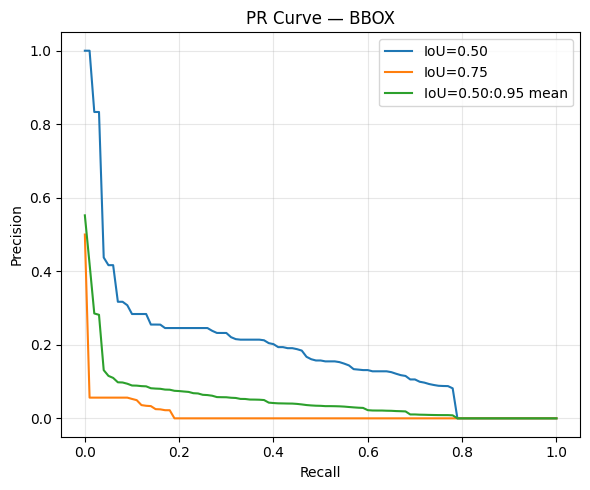

Saved: /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/eval/pr_bbox_20251027_203258.png


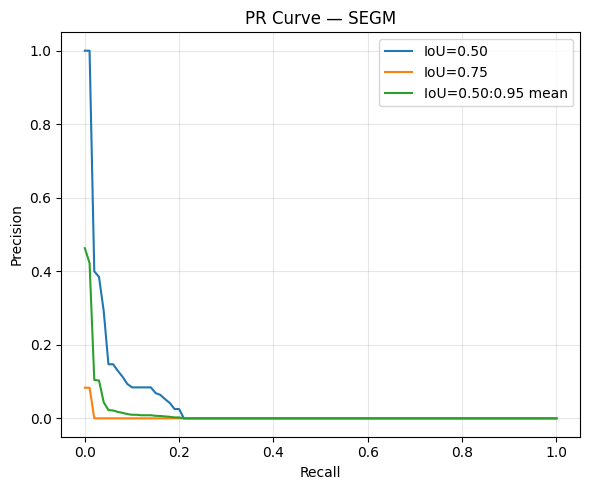

Saved: /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/eval/pr_segm_20251027_203258.png

✅ Wrote minimal summary: /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/eval/metrics_summary_minimal_20251027_203258.txt


In [19]:
# === COCO eval (prints ONLY AR@medium and AR@large) + optional PR + summary (NEW CELL) ===
!pip -q install pycocotools==2.0.7
import json, numpy as np, matplotlib.pyplot as plt, time
from pathlib import Path
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def run_coco(iou_type, gt_json: Path, dt_json: Path):
    coco_gt = COCO(str(gt_json))
    dets = json.loads(Path(dt_json).read_text())
    if isinstance(dets, dict):  # normalize if needed
        dets = dets.get("annotations", [])
    coco_dt = coco_gt.loadRes(dets)
    ce = COCOeval(coco_gt, coco_dt, iouType=iou_type)
    ce.evaluate(); ce.accumulate(); ce.summarize()  # full eval (we'll extract just 2 metrics)
    names = [
        "AP@[IoU=0.50:0.95]|area=all|maxDets=100",
        "AP@[IoU=0.50]     |area=all|maxDets=100",
        "AP@[IoU=0.75]     |area=all|maxDets=100",
        "AP@[area=small]   |IoU=0.50:0.95|maxDets=100",
        "AP@[area=medium]  |IoU=0.50:0.95|maxDets=100",
        "AP@[area=large]   |IoU=0.50:0.95|maxDets=100",
        "AR@[IoU=0.50:0.95]|area=all|maxDets=1",
        "AR@[IoU=0.50:0.95]|area=all|maxDets=10",
        "AR@[IoU=0.50:0.95]|area=all|maxDets=100",
        "AR@[area=small]   |IoU=0.50:0.95|maxDets=100",
        "AR@[area=medium]  |IoU=0.50:0.95|maxDets=100",
        "AR@[area=large]   |IoU=0.50:0.95|maxDets=100",
    ]
    stats = ce.stats.tolist() if ce.stats is not None else [None]*12
    metrics = {k: (float(v) if v is not None else None) for k, v in zip(names, stats)}
    return metrics, ce

def save_pr(ce: COCOeval, title: str, out_file: Path):
    precis = ce.eval.get("precision", None)  # (T,R,K,A,M)
    if precis is None:
        return
    rec   = ce.params.recThrs
    ious  = list(ce.params.iouThrs)
    prmat = precis[:, :, 0, 0, 2]  # K=1, area=all, maxDets=100
    plt.figure(figsize=(6,5))
    plt.plot(rec, prmat[ious.index(0.5)], label="IoU=0.50")
    plt.plot(rec, prmat[ious.index(0.75)], label="IoU=0.75")
    plt.plot(rec, prmat.mean(axis=0), label="IoU=0.50:0.95 mean")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    plt.savefig(out_file, dpi=150); plt.show()
    print("Saved:", out_file)

# ---- Run eval for bbox & segm (we will only print AR@medium and AR@large) ----
bbox_metrics, bbox_eval = run_coco("bbox", TMP_GT_JSON, DT_BBOX_SCALED)
segm_metrics, segm_eval = run_coco("segm", TMP_GT_JSON, DT_SEGM_SCALED)

# ---- Print ONLY the two you asked for (SEGM primary) ----
AR_MED_KEY = "AR@[area=medium]  |IoU=0.50:0.95|maxDets=100"
AR_LRG_KEY = "AR@[area=large]   |IoU=0.50:0.95|maxDets=100"

print("\n==== INSTANCE SEGMENTATION (SEGM) — Key Recall Metrics ====")
print(f"{AR_MED_KEY} = {segm_metrics.get(AR_MED_KEY):.3f}")
print(f"{AR_LRG_KEY} = {segm_metrics.get(AR_LRG_KEY):.3f}")

# (Optional) also show the same two for BBOX so you can compare:
print("\n[Optional] BBOX — same recall metrics for reference:")
print(f"{AR_MED_KEY} = {bbox_metrics.get(AR_MED_KEY):.3f}")
print(f"{AR_LRG_KEY} = {bbox_metrics.get(AR_LRG_KEY):.3f}")

# ---- Optional: PR curves (keep if you still want the images) ----
stamp_all = time.strftime("%Y%m%d_%H%M%S")
PR_BBOX_PNG = EVAL_DIR / f"pr_bbox_{stamp_all}.png"
PR_SEGM_PNG = EVAL_DIR / f"pr_segm_{stamp_all}.png"
save_pr(bbox_eval, "PR Curve — BBOX", PR_BBOX_PNG)
save_pr(segm_eval, "PR Curve — SEGM", PR_SEGM_PNG)

# ---- Minimal summary with ONLY the two requested metrics ----
SUMMARY_TXT = EVAL_DIR / f"metrics_summary_minimal_{stamp_all}.txt"
lines = []
lines.append("==== Minimal Validation Summary (Requested Metrics Only) ====\n")
lines.append(f"Checkpoint: {latest}\n")
lines.append(f"GT (patched): {TMP_GT_JSON}\n")
lines.append(f"Detections (scaled):\n  BBOX: {DT_BBOX_SCALED}\n  SEGM: {DT_SEGM_SCALED}\n\n")
lines.append("[SEGM] (Instance Segmentation)\n")
lines.append(f"{AR_MED_KEY} = {segm_metrics.get(AR_MED_KEY)}")
lines.append(f"{AR_LRG_KEY} = {segm_metrics.get(AR_LRG_KEY)}\n")
lines.append("[BBOX] (Reference)\n")
lines.append(f"{AR_MED_KEY} = {bbox_metrics.get(AR_MED_KEY)}")
lines.append(f"{AR_LRG_KEY} = {bbox_metrics.get(AR_LRG_KEY)}\n")
lines.append(f"PR plots (optional):\n  {PR_BBOX_PNG}\n  {PR_SEGM_PNG}\n")
SUMMARY_TXT.write_text("\n".join(lines))
print("\n Wrote minimal summary:", SUMMARY_TXT)


✅ Weights loaded from: /content/drive/MyDrive/fallen_trees_runs/swinv2_maskrcnn_tiles/epoch_40.pth
Using image: /content/drive/MyDrive/fallen_trees_coco_tiles/images/val/1032.png


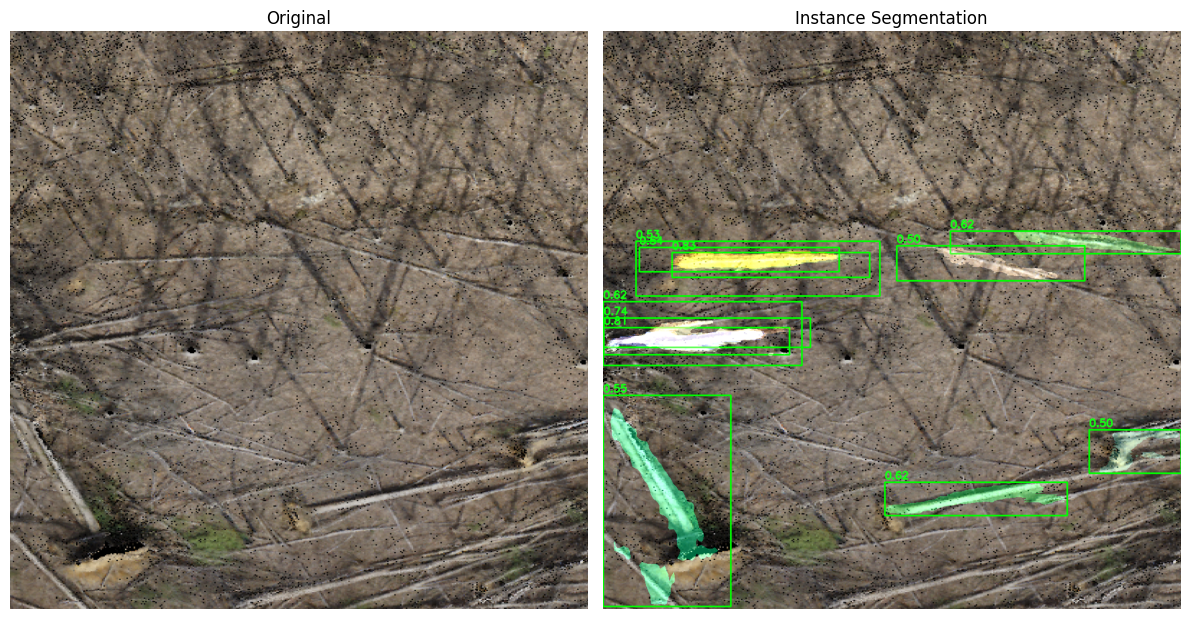

In [23]:
# === Visualize instance segmentation: BEFORE vs AFTER (fixed checkpoint loading) ===
import torch, random, cv2, numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# ---- inputs you may change ----
BEST_CKPT_PATH = latest  # or set to a specific .pth path
VAL_DIR = Path("/content/drive/MyDrive/fallen_trees_coco_tiles/images/val")
SCORE_THR = 0.5          # show only confident detections
MASK_THR  = 0.5          # binarize mask logits

# ---- robust checkpoint loader (handles {"model":..., "epoch":...} and plain sd) ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_checkpoint_into_model(model, ckpt_path, device):
    blob = torch.load(ckpt_path, map_location=device)
    state = blob.get("model", blob)
    try:
        model.load_state_dict(state, strict=True)
    except RuntimeError as e:
        print("Strict load failed, retrying strict=False.\nDetails:\n", e)
        missing_unexpected = model.load_state_dict(state, strict=False)
        print("Missing keys:", missing_unexpected.missing_keys)
        print("Unexpected keys:", missing_unexpected.unexpected_keys)

model.to(device).eval()
load_checkpoint_into_model(model, BEST_CKPT_PATH, device)
print(f" Weights loaded from: {BEST_CKPT_PATH}")

# ---- pick an image (random from val if you don't specify) ----
cand = sorted([*VAL_DIR.glob("*.jpg"), *VAL_DIR.glob("*.jpeg"), *VAL_DIR.glob("*.png")])
if not cand:
    raise FileNotFoundError(f"No images found under {VAL_DIR}")
sample_img_path = str(random.choice(cand))
print("Using image:", sample_img_path)

# ---- run inference ----
with torch.no_grad():
    img = Image.open(sample_img_path).convert("RGB")
    img_np = np.array(img)
    # torchvision models expect tensor [C,H,W] in [0,1]
    img_t = torch.from_numpy(img_np).permute(2,0,1).float()/255.0
    out = model([img_t.to(device)])[0]

# ---- draw masks & boxes ----
pred_img = img_np.copy()
boxes  = out.get("boxes", torch.empty(0,4)).detach().cpu().numpy()
scores = out.get("scores", torch.empty(0)).detach().cpu().numpy()
masks  = out.get("masks", torch.empty(0,1,*img_np.shape[:2])).detach().cpu().numpy()

if masks.ndim == 4:   # [N,1,H,W] -> [N,H,W]
    masks = masks[:,0]
elif masks.ndim == 2: # single mask case
    masks = masks[None, ...]

shown = 0
for i in range(len(scores)):
    if scores[i] < SCORE_THR:
        continue
    # mask overlay
    if i < len(masks):
        m = (masks[i] > MASK_THR).astype(np.uint8)
        color = np.random.randint(0, 255, size=3, dtype=np.uint8)
        overlay = np.zeros_like(pred_img, dtype=np.uint8)
        overlay[m.astype(bool)] = color
        pred_img = cv2.addWeighted(pred_img, 1.0, overlay, 0.45, 0)

    # box + score
    if i < len(boxes):
        x1,y1,x2,y2 = boxes[i].astype(int)
        cv2.rectangle(pred_img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(pred_img, f"{scores[i]:.2f}", (x1, max(0,y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (20,255,20), 2)
    shown += 1

if shown == 0:
    print(f" No predictions above SCORE_THR={SCORE_THR}. Try lowering it or picking another image.")

# ---- show before vs after ----
plt.figure(figsize=(12,24))
plt.subplot(1,2,1); plt.imshow(img_np);  plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(pred_img); plt.title("Instance Segmentation"); plt.axis("off")
plt.tight_layout(); plt.show()
